In [1]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
# import mlgrad.regular as regular
import mlgrad.weights as weights
from mlgrad.utils import array_exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-ticks'])

import sys
print(sys.version)

3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', usecols=["log.Te", "log.light"], )

In [3]:
len(df)

47

In [4]:
Y = df["log.light"].values
X = df["log.Te"].values

X -= np.median(X)
Y -= np.median(Y)

# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

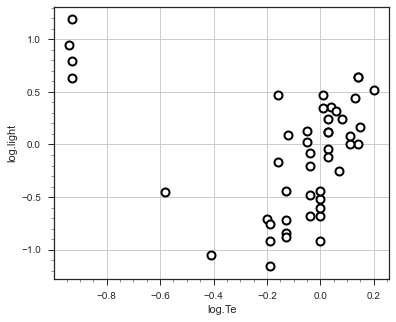

In [5]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=2.)
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [6]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [7]:
def curve_fit_and_errors(alg):
    err = np.abs(Y - alg.risk.model.evaluate_all(Xs))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('Fit curve')
    plt.plot(alg.lvals)
    plt.xlabel('step')
    plt.ylabel('mean of errors')
    plt.minorticks_on()
    plt.subplot(1,2,2)
    plt.title('Errors')
    plt.plot(sorted(err), marker='s', markersize='6')
    plt.minorticks_on()
    plt.xlabel('error rank')
    plt.ylabel('error value')
    plt.show()
    return err

In [8]:
mod_ls = model.LinearModel(1)
mod_ls.init()

step: 1
K=1000 param=[-0.13334883 -0.41327339]


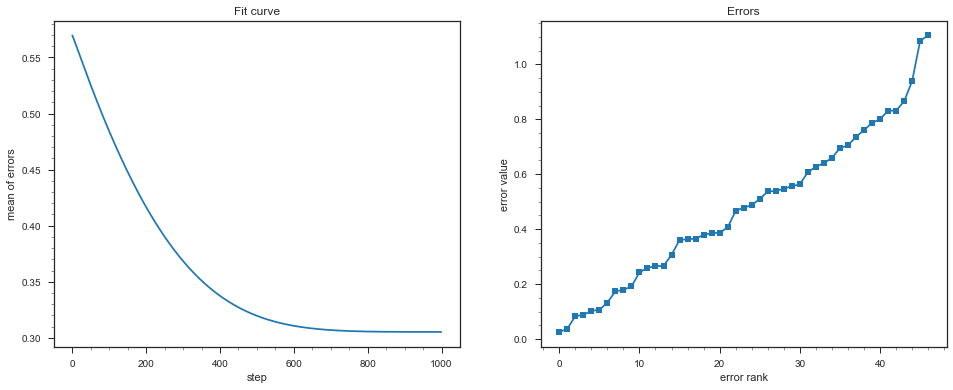

In [9]:
alg_ls = regr.regression(Xs, Y, mod_ls)
err_ls = curve_fit_and_errors(alg_ls)

In [10]:
mod_wm_irls = model.LinearModel(1)
mod_wm_irls.init()

step: 1


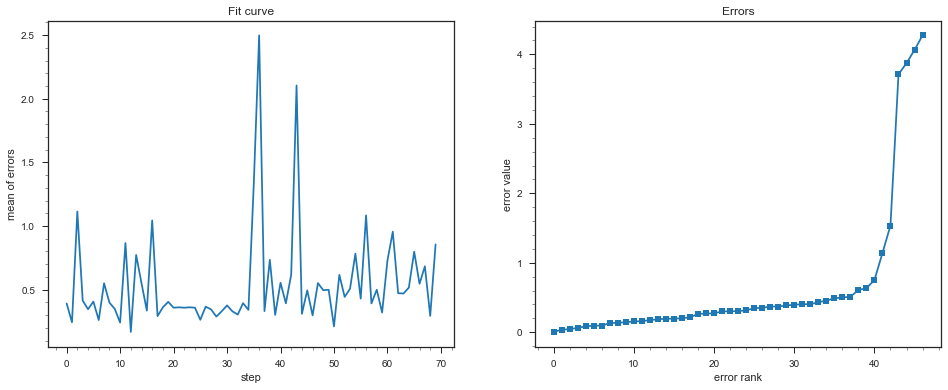

In [11]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=func.Quantile_Sqrt(0.85, 0.001))
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, avrfunc=avg_wm_irls, h=0.01, n_iter2=70)
err_wm_irls = curve_fit_and_errors(alg_wm_irls)

In [12]:
mod_swm_irls = model.LinearModel(1)
mod_swm_irls.init()

step: 1


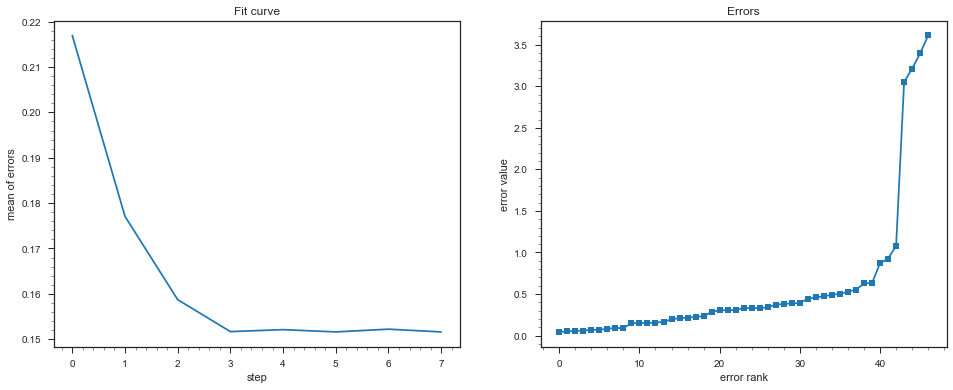

In [13]:
avg_swm_irls = regr.averaging_function('SWM', rhofunc=func.QuantileFunc(0.85, func.Sqrt(0.001)))
alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, avrfunc=avg_swm_irls, h=0.001, tol=1.0e-8)
err_swm_irls = curve_fit_and_errors(alg_swm_irls)

In [14]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [15]:
mod_r_irls = model.LinearModel(1)
mod_r_irls.init()

step: 1


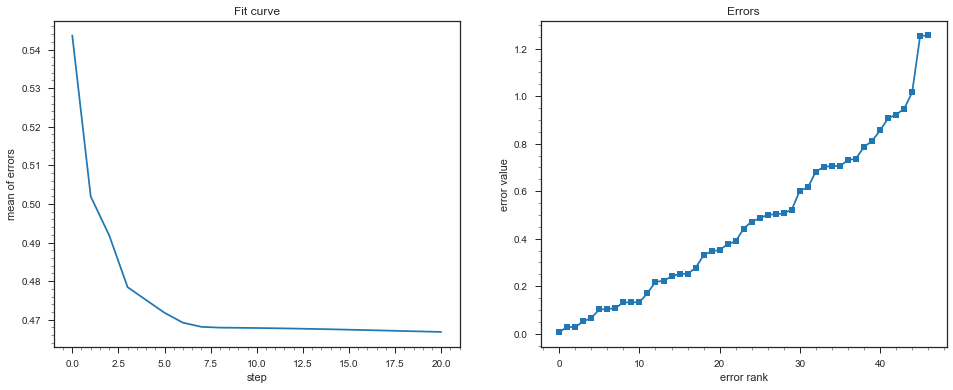

In [16]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rhofunc=func.Sqrt(0.001))
err_r_irls = curve_fit_and_errors(alg_r_irls)

In [17]:
# mod_wm_ls = model.LinearModel(1)
# mod_wm_ls.init()

In [18]:
# avg_wm_ls = regr.averaging_function('WM', rhofunc=func.Quantile_Sqrt(0.84, 0.001))
# alg_wm_ls = regr.m_regression(Xs, Y, mod_wm_ls, avrfunc=avg_wm_ls, h=0.1, tol=1.0e-8)
# err_wm_ls = curve_fit_and_errors(alg_wm_ls)

In [19]:
mod_hm_irls = model.LinearModel(1)
mod_hm_irls.init()

step: 1


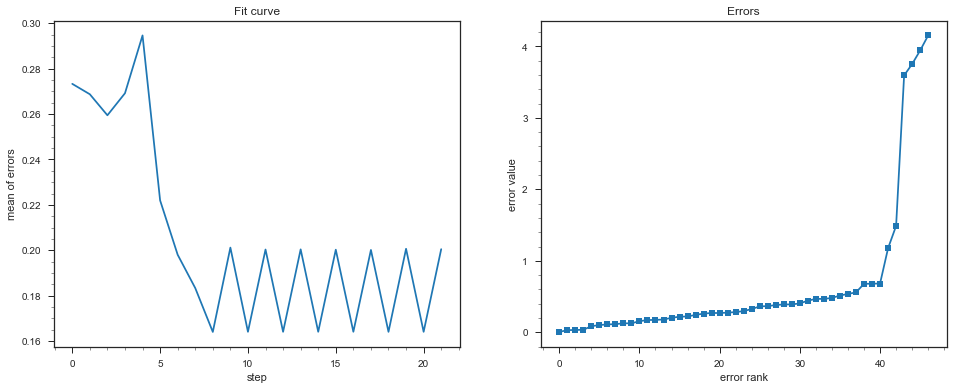

In [20]:
avg_hm_irls = regr.averaging_function('HM', rhofunc=func.Quantile_Sqrt(0.85, 0.001))
alg_hm_irls = regr.m_regression_irls(Xs, Y, mod_hm_irls, avrfunc=avg_hm_irls, h=0.1, tol=1.0e-9, n_iter2=22, tol2=1.0e-5)
err_hm_irls = curve_fit_and_errors(alg_hm_irls)

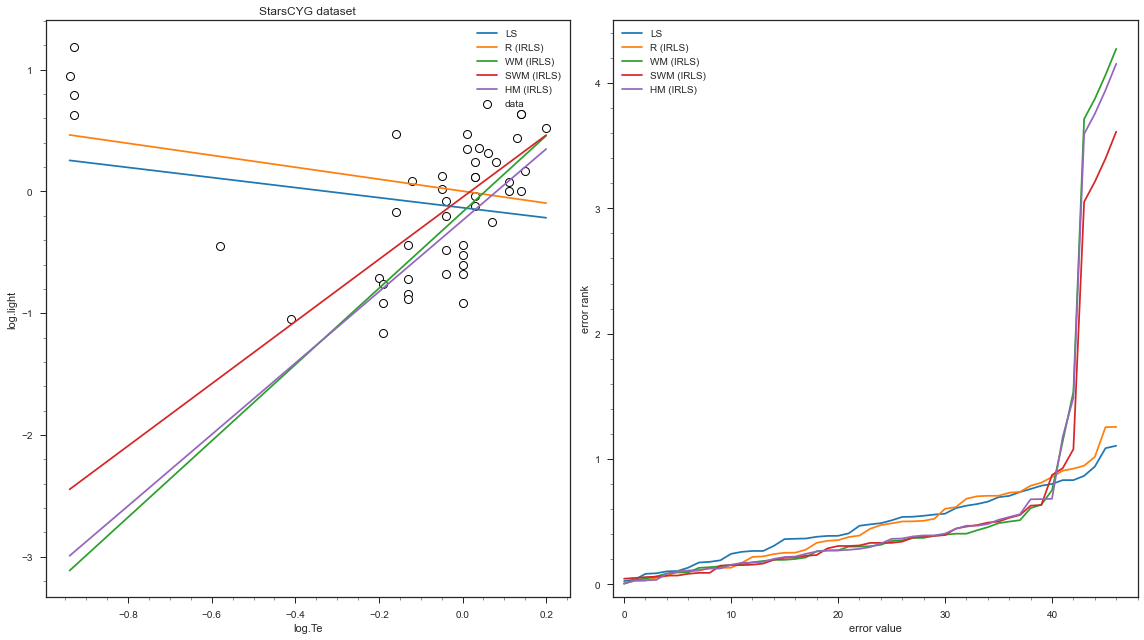

In [38]:
plt.figure(figsize=(16.0, 9.0))
plt.subplot(1,2,1)
plt.title('StarsCYG dataset')
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=1., label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), label=r'WM (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), label=r'WM (LS)')
plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), label=r'SWM (IRLS)')
plt.plot(X0, mod_hm_irls.evaluate_all(X0.reshape(-1,1)), label=r'HM (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), label=r'WM (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), label=r'WM (LS)')
plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_hm_irls.evaluate_all(Xs))), label=r'HM (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('error value')
plt.ylabel('error rank')
plt.ylim(-0.1, 4.5)
plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [22]:
40/47

0.851063829787234